In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
# Change to the desired directory
import os
os.chdir('/content/drive/MyDrive/Task-2')

In [8]:
pip install torch torchvision matplotlib

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [10]:
# Transform for input (grayscale) and output (original)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))  # Resize for simplicity
])

# Load MNIST Dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split input-output: Grayscale (input) and original (output)
def preprocess_data(data):
    input_img = transforms.Grayscale()(data)
    return input_img, data

processed_data = [(preprocess_data(img)[0], preprocess_data(img)[1]) for img, _ in dataset]
data_loader = DataLoader(processed_data, batch_size=16, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.27MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.10MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [11]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.Sigmoid()  # Output normalized to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [12]:
def add_noise(img, noise_level):
    noise = torch.randn_like(img) * noise_level
    return img + noise, noise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 5
for epoch in range(epochs):
    model.train()
    for i, (input_images, target_images) in enumerate(data_loader):
        input_images, target_images = input_images.to(device), target_images.to(device)

        # Add noise to the target
        noisy_images, noise = add_noise(target_images, noise_level=0.1)

        # Predict the noise
        predicted_noise = model(noisy_images)

        # Loss between predicted and actual noise
        loss = criterion(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch {epoch}, Step {i}, Loss: {loss.item()}")


/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch 0, Step 0, Loss: 0.20921587944030762
Epoch 0, Step 100, Loss: 0.010050025768578053
Epoch 0, Step 200, Loss: 0.009971009567379951
Epoch 0, Step 300, Loss: 0.010217755101621151
Epoch 0, Step 400, Loss: 0.009975995868444443
Epoch 0, Step 500, Loss: 0.010060882195830345
Epoch 0, Step 600, Loss: 0.01012628898024559
Epoch 0, Step 700, Loss: 0.010074425488710403
Epoch 0, Step 800, Loss: 0.010119996033608913
Epoch 0, Step 900, Loss: 0.010017729364335537
Epoch 0, Step 1000, Loss: 0.009892974980175495
Epoch 0, Step 1100, Loss: 0.01015459094196558
Epoch 0, Step 1200, Loss: 0.009782164357602596
Epoch 0, Step 1300, Loss: 0.00997781939804554
Epoch 0, Step 1400, Loss: 0.009974198415875435
Epoch 0, Step 1500, Loss: 0.009945191442966461
Epoch 0, Step 1600, Loss: 0.010190320201218128
Epoch 0, Step 1700, Loss: 0.010229961946606636
Epoch 0, Step 1800, Loss: 0.009966772049665451
Epoch 0, Step 1900, Loss: 0.010069698095321655
Epoch 0, Step 2000, Loss: 0.010059215128421783
Epoch 0, Step 2100, Loss: 0.0

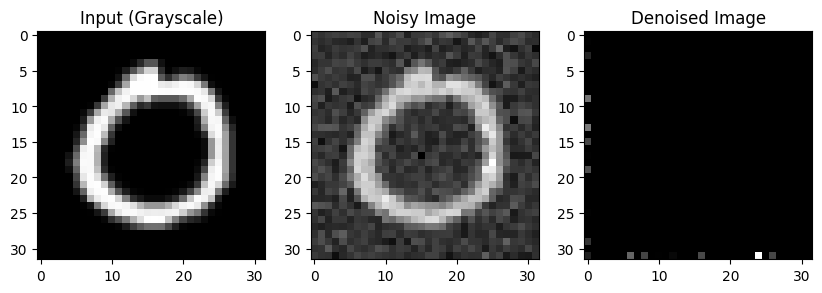

In [13]:
model.eval()
with torch.no_grad():
    for input_images, target_images in data_loader:
        input_images, target_images = input_images.to(device), target_images.to(device)
        noisy_images, _ = add_noise(target_images, noise_level=0.1)
        denoised_images = model(noisy_images)

        # Show results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input (Grayscale)")
        plt.imshow(input_images[0].cpu().squeeze(), cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title("Noisy Image")
        plt.imshow(noisy_images[0].cpu().squeeze(), cmap="gray")
        plt.subplot(1, 3, 3)
        plt.title("Denoised Image")
        plt.imshow(denoised_images[0].cpu().squeeze(), cmap="gray")
        plt.show()
        break